# Import Library

In [3]:
import pandas as pd
import numpy as np
import random
import datetime
from collections import defaultdict
import copy
import matplotlib.pyplot as plt

print("Libraries imported successfully!")

Libraries imported successfully!


# Data Preparation

In [4]:
# Memuat dataset
try:
    df_mk = pd.read_csv('/home/emery/Documents/Puma/mk_dsi.csv')
    df_ruang = pd.read_csv('/home/emery/Documents/Puma/ruang_kuliah.csv')
except FileNotFoundError:
    print("Pastikan file 'mk_dsi.csv' dan 'ruang_kuliah.csv' ada di direktori yang sama.")
    # Membuat dataframe dummy jika file tidak ditemukan agar sisa kode bisa berjalan
    df_mk = pd.DataFrame()
    df_ruang = pd.DataFrame()

# Membersihkan data dan mengisi nilai yang kosong
# Kita asumsikan 'Nama Dosen' yang kosong adalah mata kuliah yang belum ada dosennya
df_mk['Nama Dosen'] = df_mk['Nama Dosen'].fillna('Belum Ada Dosen')
# Mengubah nama kolom agar konsisten
df_mk.columns = ['kode_mk', 'nama_mk', 'prodi', 'prioritas', 'berminat', 'dosen_id']
df_ruang.columns = ['kode_ruang', 'lokasi', 'lantai', 'keterangan']


print("Data Mata Kuliah (5 baris pertama):")
print(df_mk.head())
print("\n" + "="*50 + "\n")
print("Data Ruang Kuliah (5 baris pertama):")
print(df_ruang.head())

# Mengambil list unik
list_mk = df_mk.to_dict('records')
list_ruang = df_ruang['kode_ruang'].unique().tolist()
list_dosen = df_mk['dosen_id'].unique().tolist()

Data Mata Kuliah (5 baris pertama):
    kode_mk                              nama_mk  \
0  CIE61101           Perkembangan Peserta Didik   
1  CIE61102           Perkembangan Peserta Didik   
2  CIE61102        Filsafat Pendidikan dan Sains   
3  CIE61103        Filsafat Pendidikan dan Sains   
4  CIE61103  Komunikasi dan Teknologi Pendidikan   

                            prodi  prioritas  \
0  Pendidikan Teknologi Informasi          1   
1  Pendidikan Teknologi Informasi          2   
2  Pendidikan Teknologi Informasi          1   
3  Pendidikan Teknologi Informasi          2   
4  Pendidikan Teknologi Informasi          1   

                                     berminat         dosen_id  
0  Koordinator Pengelola, Pengelola, Pengampu             39.0  
1                                    Pengampu             59.0  
2                                    Pengampu  Belum Ada Dosen  
3                                    Pengampu            103.0  
4  Koordinator Pengelola, Pengelola, 

# Definisi Ruangan

In [5]:
# --- Definisi Slot Waktu ---
# Asumsi: 1 slot = 50 menit
def generate_time_slots():
    slots = []
    days = {
        "Senin": 0, "Selasa": 1, "Rabu": 2, "Kamis": 3, "Jumat": 4
    }
    
    for day_name, day_index in days.items():
        # Waktu normal: 07:00 - 18:00
        start_time = datetime.datetime.strptime("07:00", "%H:%M")
        end_time = datetime.datetime.strptime("18:00", "%H:%M")
        
        # Waktu istirahat
        if day_name in ["Senin", "Selasa", "Rabu", "Kamis"]:
            break_start = datetime.datetime.strptime("12:10", "%H:%M")
            break_end = datetime.datetime.strptime("12:30", "%H:%M")
        elif day_name == "Jumat":
            break_start = datetime.datetime.strptime("11:15", "%H:%M")
            break_end = datetime.datetime.strptime("12:30", "%H:%M")
        
        current_time = start_time
        while current_time < end_time:
            slot_end_time = current_time + datetime.timedelta(minutes=50)
            # Cek apakah slot berada di luar jam istirahat
            if not (current_time >= break_start and slot_end_time <= break_end):
                 slots.append(f"{day_name}_{current_time.strftime('%H:%M')}-{slot_end_time.strftime('%H:%M')}")
            current_time = slot_end_time
            
    return slots

time_slots = generate_time_slots()

# --- Definisi Ruangan ---
# Asumsi: Ruang lab memiliki kata "Lab" atau "Praktikum" dalam keterangannya
ruang_lab = [r['kode_ruang'] for i, r in df_ruang.iterrows() if 'lab' in r['keterangan'].lower() or 'praktikum' in r['keterangan'].lower()]
ruang_reguler = [r for r in list_ruang if r not in ruang_lab]

# Asumsi: Mata kuliah praktikum punya kata "Praktikum" di namanya
for mk in list_mk:
    if 'praktikum' in mk['nama_mk'].lower():
        mk['jenis'] = 'lab'
    else:
        mk['jenis'] = 'reguler'

print(f"Total Slot Waktu Tersedia: {len(time_slots)}")
print(f"Total Ruang Reguler: {len(ruang_reguler)}")
print(f"Total Ruang Lab: {len(ruang_lab)}")
# print("\nContoh Slot Waktu:", time_slots[:5])

Total Slot Waktu Tersedia: 70
Total Ruang Reguler: 44
Total Ruang Lab: 0


# Initiate Population

In [6]:
def create_random_individual(courses, rooms_reg, rooms_lab, times):
    """Membuat satu individu jadwal acak."""
    schedule = []
    for course in courses:
        # Pilih ruangan berdasarkan jenis mata kuliah
        room = random.choice(rooms_lab) if course['jenis'] == 'lab' else random.choice(rooms_reg)
        
        # Pilih waktu acak
        time = random.choice(times)
        
        schedule.append({
            'kode_mk': course['kode_mk'],
            'nama_mk': course['nama_mk'],
            'dosen_id': course['dosen_id'],
            'prioritas': course['prioritas'],
            'ruang': room,
            'waktu': time
        })
    return schedule

def initialize_population(pop_size, courses, rooms_reg, rooms_lab, times):
    """Membuat populasi awal dari jadwal-jadwal acak."""
    return [create_random_individual(courses, rooms_reg, rooms_lab, times) for _ in range(pop_size)]

# Creating Fitness Function (Evalute Schedule)

In [7]:
# Bobot untuk penalti dan bonus
HARD_CONSTRAINT_PENALTY = 1000
SOFT_CONSTRAINT_PENALTY = 10 

def calculate_fitness(schedule, df_ruang):
    """Menghitung skor fitness untuk satu jadwal."""
    hard_constraint_violations = 0
    soft_constraint_score = 0
    
    # --- HARD CONSTRAINTS ---
    
    # Menggunakan defaultdict untuk memudahkan pengecekan
    room_time_usage = defaultdict(list)
    dosen_time_usage = defaultdict(list)

    for i, s in enumerate(schedule):
        # 1. Tidak boleh ada dua mata kuliah di ruang dan waktu yang sama
        if s['kode_mk'] in room_time_usage[(s['ruang'], s['waktu'])]:
            hard_constraint_violations += 1
        room_time_usage[(s['ruang'], s['waktu'])].append(s['kode_mk'])
        
        # 2 & 3. Dosen tidak boleh mengajar lebih dari satu MK di waktu yang sama
        if s['dosen_id'] in dosen_time_usage[s['waktu']]:
            hard_constraint_violations += 1
        dosen_time_usage[s['waktu']].append(s['dosen_id'])

    # 5. Mata kuliah praktikum harus di ruang lab (sudah ditangani saat inisialisasi,
    # tapi bisa dicek lagi di sini untuk validasi)
    # (Constraint 4, waktu, sudah ditangani oleh pembuatan `time_slots`)

    # --- SOFT CONSTRAINTS ---

    dosen_movement = defaultdict(list)
    for s in schedule:
        dosen_movement[s['dosen_id']].append({'waktu': s['waktu'], 'ruang': s['ruang']})

    # 1. Prioritas Mata Kuliah
    # Semakin kecil nilainya, semakin diprioritaskan -> semakin kecil penaltinya
    total_priority = sum([s['prioritas'] for s in schedule])
    soft_constraint_score += total_priority
    
    # 2. Minimalkan Pergerakan Dosen (Perbedaan Lantai)
    for dosen_id, movements in dosen_movement.items():
        # Urutkan jadwal berdasarkan waktu
        sorted_movements = sorted(movements, key=lambda x: time_slots.index(x['waktu']))
        
        for i in range(len(sorted_movements) - 1):
            try:
                lantai_1 = df_ruang[df_ruang['kode_ruang'] == sorted_movements[i]['ruang']]['lantai'].iloc[0]
                lantai_2 = df_ruang[df_ruang['kode_ruang'] == sorted_movements[i+1]['ruang']]['lantai'].iloc[0]
                
                # Cek jika jadwalnya berurutan
                if time_slots.index(sorted_movements[i+1]['waktu']) == time_slots.index(sorted_movements[i]['waktu']) + 1:
                    perbedaan_lantai = abs(lantai_1 - lantai_2)
                    if perbedaan_lantai > 1: # Penalti jika pindah lebih dari 1 lantai
                        soft_constraint_score += perbedaan_lantai * SOFT_CONSTRAINT_PENALTY
            except IndexError:
                # Terjadi jika kode ruang tidak ditemukan di df_ruang
                continue
                
    # (Soft Constraint 3, preferensi waktu dosen, belum diimplementasikan karena datanya tidak ada,
    # namun bisa ditambahkan di sini jika ada datanya)

    # Total Skor Fitness
    # Semakin KECIL skor fitness, semakin BAIK jadwalnya
    total_fitness = (hard_constraint_violations * HARD_CONSTRAINT_PENALTY) + soft_constraint_score
    
    return total_fitness, hard_constraint_violations

# Implementing Puma Optimization Algorithm (POA)

In [8]:
def puma_optimization(population, courses, rooms_reg, rooms_lab, times, df_ruang, generations=100, mutation_rate=0.1):
    """Fungsi utama untuk menjalankan algoritma optimasi."""
    
    # Evaluasi populasi awal
    pop_fitness = [(ind, calculate_fitness(ind, df_ruang)) for ind in population]
    
    # Simpan jejak fitness terbaik
    best_fitness_history = []

    for gen in range(generations):
        # Urutkan populasi berdasarkan fitness (terendah ke tertinggi)
        pop_fitness.sort(key=lambda x: x[1][0])
        
        # Ambil individu terbaik (Alpha Puma)
        best_individual = pop_fitness[0][0]
        best_fitness = pop_fitness[0][1][0]
        best_violations = pop_fitness[0][1][1]
        
        best_fitness_history.append(best_fitness)
        
        print(f"Generasi {gen+1}/{generations} | Fitness Terbaik: {best_fitness} | Pelanggaran Hard: {best_violations}")
        
        # Jika solusi sempurna ditemukan (tidak ada pelanggaran)
        if best_violations == 0:
            print("\nSolusi optimal ditemukan!")
            break
        
        # Buat populasi baru
        new_population = [best_individual] # Elitisme: individu terbaik langsung masuk ke generasi baru
        
        # --- Update Populasi (Pergerakan Puma) ---
        for i in range(1, len(population)):
            current_individual = pop_fitness[i][0]
            new_individual = current_individual[:] # Salin individu
            
            # 1. Bergerak ke arah Puma Alfa (Eksploitasi)
            for j in range(len(courses)):
                if random.random() < 0.7: # Probabilitas meniru puma alfa
                    new_individual[j] = best_individual[j]
            
            # 2. Mutasi (Eksplorasi/Lompatan Acak)
            if random.random() < mutation_rate:
                gene_to_mutate = random.randint(0, len(courses) - 1)
                
                # Pilih waktu atau ruang baru secara acak
                if random.random() < 0.5:
                     new_individual[gene_to_mutate]['waktu'] = random.choice(times)
                else:
                    course_type = new_individual[gene_to_mutate]['nama_mk']
                    if 'praktikum' in course_type.lower():
                        new_individual[gene_to_mutate]['ruang'] = random.choice(rooms_lab)
                    else:
                        new_individual[gene_to_mutate]['ruang'] = random.choice(rooms_reg)

            new_population.append(new_individual)
            
        population = new_population
        pop_fitness = [(ind, calculate_fitness(ind, df_ruang)) for ind in population]
        
    # Kembalikan jadwal terbaik yang ditemukan
    final_best_individual = min(pop_fitness, key=lambda x: x[1][0])
    return final_best_individual[0], final_best_individual[1], best_fitness_history

# Running the Optimization

Generasi 1/50 | Fitness Terbaik: 107719 | Pelanggaran Hard: 104
Generasi 2/50 | Fitness Terbaik: 94789 | Pelanggaran Hard: 91
Generasi 3/50 | Fitness Terbaik: 92479 | Pelanggaran Hard: 89
Generasi 4/50 | Fitness Terbaik: 86719 | Pelanggaran Hard: 83
Generasi 5/50 | Fitness Terbaik: 83799 | Pelanggaran Hard: 80
Generasi 6/50 | Fitness Terbaik: 81009 | Pelanggaran Hard: 77
Generasi 7/50 | Fitness Terbaik: 82809 | Pelanggaran Hard: 79
Generasi 8/50 | Fitness Terbaik: 81549 | Pelanggaran Hard: 78
Generasi 9/50 | Fitness Terbaik: 81609 | Pelanggaran Hard: 78
Generasi 10/50 | Fitness Terbaik: 81599 | Pelanggaran Hard: 78
Generasi 11/50 | Fitness Terbaik: 82439 | Pelanggaran Hard: 79
Generasi 12/50 | Fitness Terbaik: 80489 | Pelanggaran Hard: 77
Generasi 13/50 | Fitness Terbaik: 81489 | Pelanggaran Hard: 78
Generasi 14/50 | Fitness Terbaik: 80459 | Pelanggaran Hard: 77
Generasi 15/50 | Fitness Terbaik: 82479 | Pelanggaran Hard: 79
Generasi 16/50 | Fitness Terbaik: 83429 | Pelanggaran Hard: 80

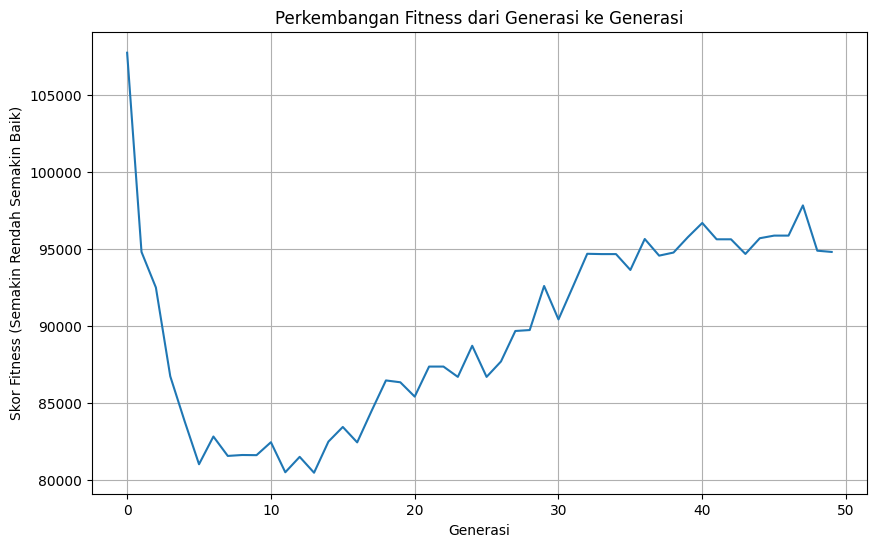

In [9]:
# --- PARAMETER ALGORITMA ---
POPULATION_SIZE = 50      # Jumlah jadwal dalam satu populasi
GENERATIONS = 50         # Berapa kali algoritma akan mencoba memperbaiki solusi
MUTATION_RATE = 0.2       # Seberapa sering jadwal akan diubah secara acak

# 1. Inisialisasi Populasi
initial_population = initialize_population(POPULATION_SIZE, list_mk, ruang_reguler, ruang_lab, time_slots)

# 2. Jalankan Optimasi
best_schedule, best_fitness_score, history = puma_optimization(
    initial_population, 
    list_mk, 
    ruang_reguler, 
    ruang_lab, 
    time_slots, 
    df_ruang,
    generations=GENERATIONS, 
    mutation_rate=MUTATION_RATE
)

# 3. Tampilkan Hasil
print("\n" + "="*50)
print("           HASIL PENJADWALAN OPTIMAL")
print("="*50)
print(f"Skor Fitness Akhir: {best_fitness_score[0]}")
print(f"Jumlah Pelanggaran Hard Constraint: {best_fitness_score[1]}")
print("="*50 + "\n")

# Konversi hasil ke DataFrame untuk tampilan yang lebih baik
df_hasil = pd.DataFrame(best_schedule)

# Mengurutkan jadwal berdasarkan hari dan waktu
df_hasil['hari'] = df_hasil['waktu'].apply(lambda x: x.split('_')[0])
df_hasil['jam'] = df_hasil['waktu'].apply(lambda x: x.split('_')[1])
df_hasil = df_hasil.sort_values(by=['hari', 'jam'])

# Simpan ke CSV
df_hasil.to_csv('jadwal_optimal.csv', index=False)
print("Jadwal optimal telah disimpan ke file 'jadwal_optimal.csv'")

# Tampilkan beberapa baris dari jadwal hasil optimasi
print("\nContoh Jadwal yang Dihasilkan:")
print(df_hasil[['hari', 'jam', 'ruang', 'nama_mk', 'dosen_id']].head(15).to_string())

# Plotting sederhana untuk melihat perkembangan fitness
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(history)
    plt.title('Perkembangan Fitness dari Generasi ke Generasi')
    plt.xlabel('Generasi')
    plt.ylabel('Skor Fitness (Semakin Rendah Semakin Baik)')
    plt.grid(True)
    plt.savefig("fitness_history.png")
    print("\nGrafik perkembangan fitness disimpan sebagai 'fitness_history.png'")
except ImportError:
    print("\nMatplotlib tidak terinstal. Lewati pembuatan grafik. Anda bisa instal dengan: %pip install matplotlib")